<a href="https://www.kaggle.com/code/jpatomaster/oxford-university-reviews-eda-wc?scriptVersionId=199778482" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# [Oxford University Reviews](https://www.kaggle.com/datasets/kanchana1990/oxford-university-reviews) - Exploratory Data Analysis and Word Clouds

__Author of notebook:__ Jorge Fatama Vera (jfatamav@aeditip.com)

# Introduction
Reviews are a way for users of a service or visitors to a place to express their experiences and impressions to others, either to promote or advise based on their previous encounters. In these reviews, users can rate their experiences on a scale (usually from 1 to 5). These ratings are used to measure user satisfaction levels and to calculate metrics that estimate how users' ratings impact potential users or visitors (for example, the Net Promoter Score or NPS).

This notebook presents the procedures and results of an exploratory data analysis (EDA) and the generation of word clouds for the dataset 'Oxford University Reviews,' which contains information about reviews of the University of Oxford.

# About the dataset

The dataset is available on Kaggle and provided by Kanchana Karunarathna ([Kaggle user kanchana1990](https://www.kaggle.com/kanchana1990)) through the [ODC Attribution License (ODC-By)](https://opendatacommons.org/licenses/by/1-0/index.html). The dataset comprises 1119 reviews from TripAdvisor on the University of Oxford. Each review includes details like the date of publication, the platform used for publishing, and the type of trip (Karunarathna, 2024).

# Analysis

## 1. Loading of data

### 1.1. Import of required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### 1.2. Load of dataset

In [2]:
df_reviews = pd.read_csv('/kaggle/input/oxford-university-reviews/university_of_oxford_tripadvisor_reviews.csv')

## 2. Preprocessing

### 2.1. Knowing the dataset

In [3]:
df_reviews.head()

helpfulVotes publishedDate publishedPlatform  rating  \
0             0    2024-10-04             OTHER       4   
1             0    2024-09-17             OTHER       4   
2             0    2024-09-16            MOBILE       5   
3             0    2024-09-07             OTHER       4   
4             0    2024-08-15            MOBILE       4   

                                                text  \
0  Visit today university of oxford amazing archi...   
1  Having some difficulty with walking and standi...   
2  Founded in the 12th century, it’s not only one...   
3  To visit this interesting museum it is essenti...   
4  伦敦到牛津的高铁一般都是从两个站出发：\n去程：London Paddington or L...   

                                 title  tripType  
0                                Happy    FAMILY  
1  Fabulous Buildings and Architecture   COUPLES  
2   One of world’s oldest universities  BUSINESS  
3       Oxford University Press Museum      SOLO  
4                                 牛津大学   FRIENDS

In [4]:
# Dimension of the dataset
df_reviews.shape

(1119, 7)

In [5]:
# Null counting on every column of dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   helpfulVotes       1119 non-null   int64 
 1   publishedDate      1119 non-null   object
 2   publishedPlatform  1119 non-null   object
 3   rating             1119 non-null   int64 
 4   text               1119 non-null   object
 5   title              1119 non-null   object
 6   tripType           1091 non-null   object
dtypes: int64(2), object(5)
memory usage: 61.3+ KB


As `info` reports, only the column `tripType` reports some null values (2.50%). Also shows that the column `publishedDate` needs to be converted into a date type if the analysis needs the year or month review.

In [6]:
# View some reviews
df_reviews[df_reviews['tripType'].isnull()].head()

helpfulVotes publishedDate publishedPlatform  rating  \
721             0    2015-05-20            MOBILE       5   
741             0    2015-04-07            MOBILE       4   
743             3    2015-04-04            MOBILE       5   
763             3    2015-02-26            MOBILE       5   
774             0    2015-02-09            MOBILE       4   

                                                  text  \
721  Visited the University with a small group of o...   
741  Being a consistent top university in the world...   
743  There are many paid sightseeing tours of Oxfor...   
763  I went to oxford a couple of weeks ago and it ...   
774  After deciding that we wanted to visit oxford ...   

                                           title tripType  
721                            How very British!      NaN  
741                                 Worth seeing      NaN  
743                       Wonderful sightseeing       NaN  
763                 Makes you want to study hard      NaN  
774  What a truly breathtaking afternoon wander.      NaN

It seems that there are not differences with this unlabeled trip-type reviews.

In [7]:
# View type values
df_reviews['tripType'].unique()

array(['FAMILY', 'COUPLES', 'BUSINESS', 'SOLO', 'FRIENDS', 'NONE', nan],
      dtype=object)

In [8]:
# View published platform values
df_reviews['publishedPlatform'].unique()

array(['OTHER', 'MOBILE', 'TABLET'], dtype=object)

### 2.2. Applying of transformations

In [9]:
# Renaming the columns
df_reviews.rename(columns={
    'helpfulVotes': 'votes',
    'publishedPlatform': 'platform',
    'text': 'description',
    'tripType': 'type',
}, inplace=True)

df_reviews.head()

votes publishedDate platform  rating  \
0      0    2024-10-04    OTHER       4   
1      0    2024-09-17    OTHER       4   
2      0    2024-09-16   MOBILE       5   
3      0    2024-09-07    OTHER       4   
4      0    2024-08-15   MOBILE       4   

                                         description  \
0  Visit today university of oxford amazing archi...   
1  Having some difficulty with walking and standi...   
2  Founded in the 12th century, it’s not only one...   
3  To visit this interesting museum it is essenti...   
4  伦敦到牛津的高铁一般都是从两个站出发：\n去程：London Paddington or L...   

                                 title      type  
0                                Happy    FAMILY  
1  Fabulous Buildings and Architecture   COUPLES  
2   One of world’s oldest universities  BUSINESS  
3       Oxford University Press Museum      SOLO  
4                                 牛津大学   FRIENDS

In [10]:
stopwords_en = set(stopwords.words('english'))

def applying_stopwords_drop(text):
    """
    Apply some formatting and transformation to a given text.
    """
    # Only english alphabet letters permitted
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Standarize the text into lowercase 
    text = text.lower()
    # Using the stopwords filter
    words = text.split()
    filtered_text = [word for word in words if word not in stopwords_en]
    return ' '.join(filtered_text)

In [11]:
df_reviews['title'] = df_reviews['title'].apply(applying_stopwords_drop)
df_reviews['description'] = df_reviews['description'].apply(applying_stopwords_drop)

df_reviews.head()

votes publishedDate platform  rating  \
0      0    2024-10-04    OTHER       4   
1      0    2024-09-17    OTHER       4   
2      0    2024-09-16   MOBILE       5   
3      0    2024-09-07    OTHER       4   
4      0    2024-08-15   MOBILE       4   

                                         description  \
0  visit today university oxford amazing architec...   
1  difficulty walking standing around decided bes...   
2  founded th century one oldest also best presti...   
3  visit interesting museum essential book ahead ...   
4  london paddington london marylebone round trip...   

                             title      type  
0                            happy    FAMILY  
1  fabulous buildings architecture   COUPLES  
2   one worlds oldest universities  BUSINESS  
3   oxford university press museum      SOLO  
4                                    FRIENDS

In [12]:
# REMEMBER: Some types are null
df_reviews['type'] = df_reviews['type'].fillna('NONE')

n_null_types = len(df_reviews[df_reviews['type'].isnull()])
# Further information (1)
assert n_null_types == 0, f"Oops! In {n_null_types} reviews type are still NaN."

In [13]:
# REMEMBER: `publishedDate` are still a object column
df_reviews['publishedDate'] = pd.to_datetime(df_reviews['publishedDate'])

# Further information (2)
assert pd.api.types.is_datetime64_any_dtype(df_reviews['publishedDate']), "Oops! The column isn't still as datetime type."

## 3. Exploration of data

### 3.1. Numerical stats

In [14]:
df_reviews.describe()

votes                  publishedDate       rating
count  1119.000000                           1119  1119.000000
mean      0.839142  2016-03-11 04:44:23.806970624     4.699732
min       0.000000            2010-12-02 00:00:00     1.000000
25%       0.000000            2014-09-27 12:00:00     5.000000
50%       0.000000            2015-11-23 00:00:00     5.000000
75%       1.000000            2017-06-19 00:00:00     5.000000
max      18.000000            2024-10-04 00:00:00     5.000000
std       1.532897                            NaN     0.592975

### 3.2. Histogram

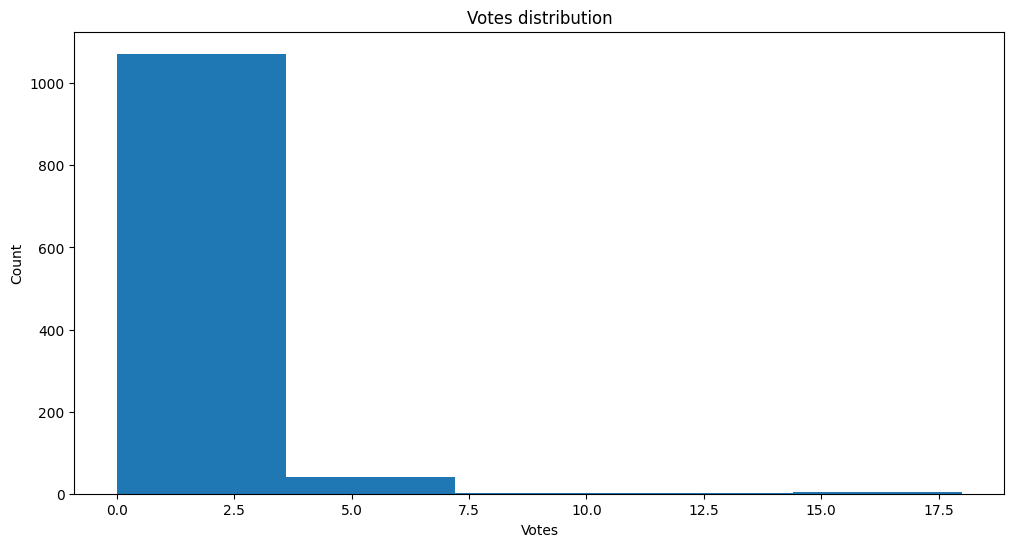

In [15]:
df_reviews['votes'].plot(kind='hist', bins=5, figsize=(12, 6))

plt.title('Votes distribution')
plt.ylabel('Count')
plt.xlabel('Votes')
plt.show()

### 3.3. Bar plots

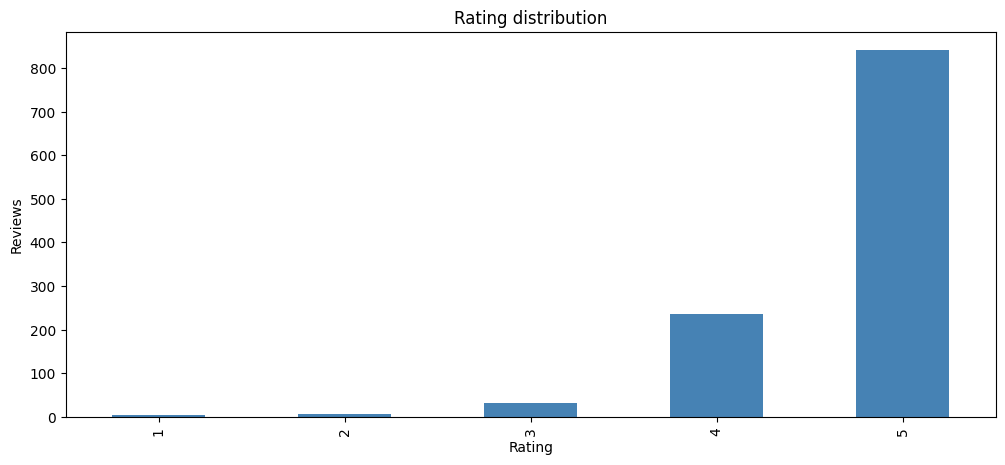

In [16]:
# Rating
groupedby_rating_count = df_reviews.groupby('rating').size().reset_index(name='count')

groupedby_rating_count.plot(kind='bar', x="rating", y="count", figsize=(12, 5), color='steelblue', )

plt.title('Rating distribution')
plt.ylabel('Reviews')
plt.xlabel('Rating')
plt.gca().get_legend().remove()
plt.show()

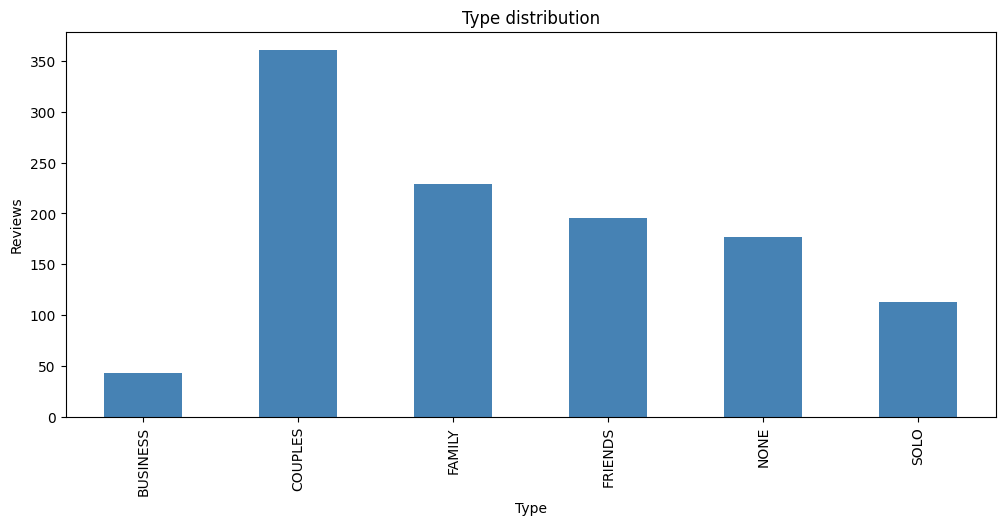

In [17]:
# Type
groupedby_type_count = df_reviews.groupby('type').size().reset_index(name='count')

groupedby_type_count.plot(kind='bar', x="type", y="count", figsize=(12, 5), color='steelblue', )

plt.title('Type distribution')
plt.ylabel('Reviews')
plt.xlabel('Type')
plt.gca().get_legend().remove()
plt.show()

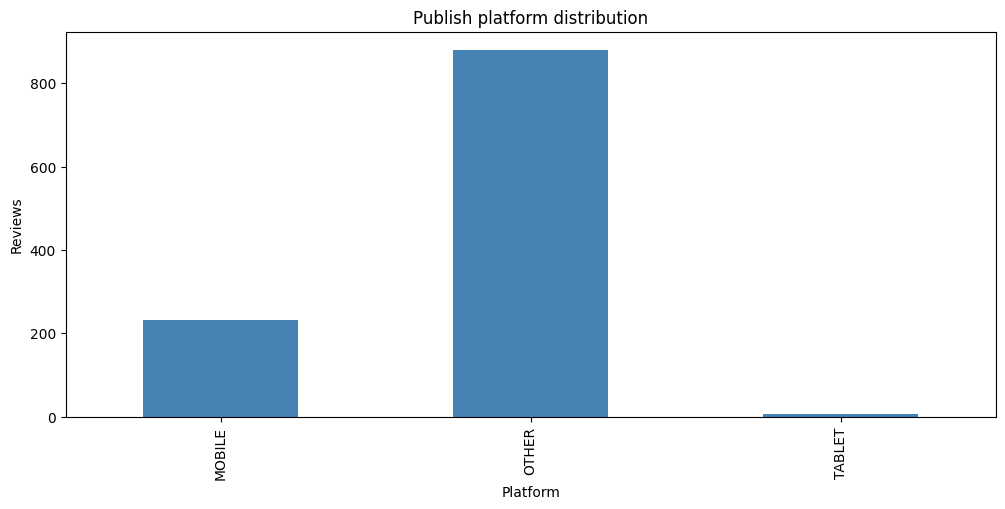

In [18]:
# Platform
groupedby_platform_count = df_reviews.groupby('platform').size().reset_index(name='count')

groupedby_platform_count.plot(kind='bar', x="platform", y="count", figsize=(12, 5), color='steelblue', )

plt.title('Publish platform distribution')
plt.ylabel('Reviews')
plt.xlabel('Platform')
plt.gca().get_legend().remove()
plt.show()

### 3.4. Line plots

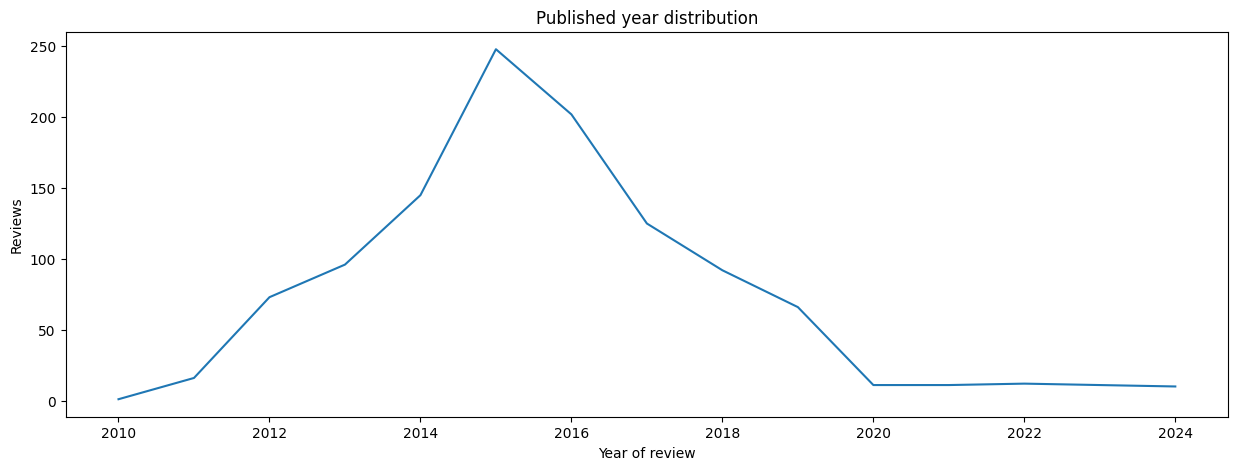

In [19]:
# Review year
review_year = pd.DatetimeIndex(df_reviews['publishedDate']).year
groupedby_review_year_count = review_year.value_counts().reset_index(name='count').rename(columns={"publishedDate": "publishedYear"})
groupedby_review_year_count.sort_values(by='publishedYear', ascending=True, inplace=True)

plt.figure(figsize=(15, 5))
plt.plot(groupedby_review_year_count['publishedYear'], groupedby_review_year_count['count'])
plt.title('Published year distribution')
plt.ylabel('Reviews')
plt.xlabel('Year of review')
plt.show()

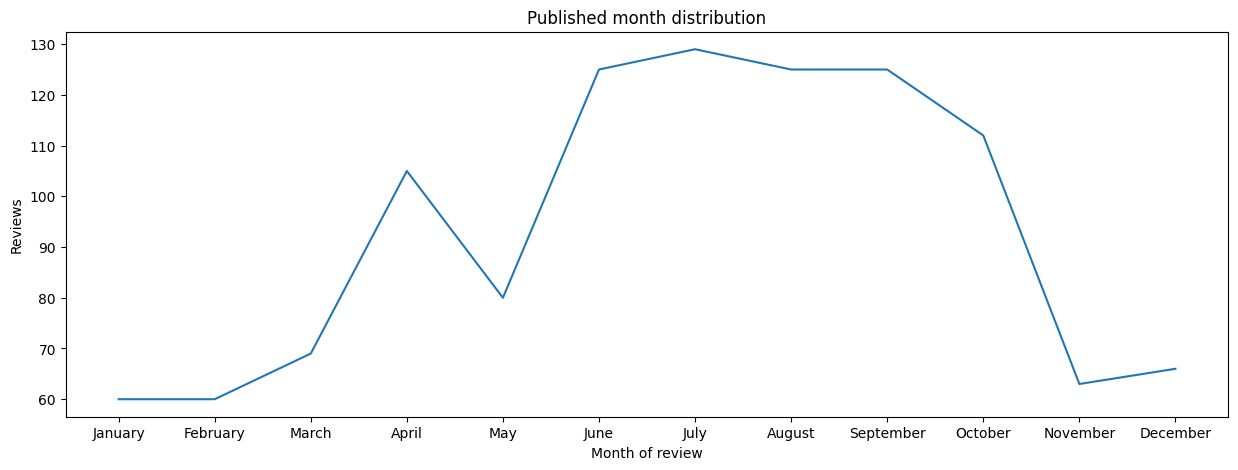

In [20]:
# Review month
review_month = pd.DataFrame()
review_month['monthNumber'] = pd.DatetimeIndex(df_reviews['publishedDate']).month
review_month['monthName'] =  df_reviews['publishedDate'].dt.strftime('%B')
groupedby_review_month_count = review_month.groupby(['monthNumber', 'monthName']).size().reset_index(name='count')
groupedby_review_month_count.sort_values(by='monthNumber', inplace=True)

plt.figure(figsize=(15, 5))
plt.plot(groupedby_review_month_count['monthName'], groupedby_review_month_count['count'])
plt.title('Published month distribution')
plt.ylabel('Reviews')
plt.xlabel('Month of review')
plt.show()

### 3.5. Scatter plot

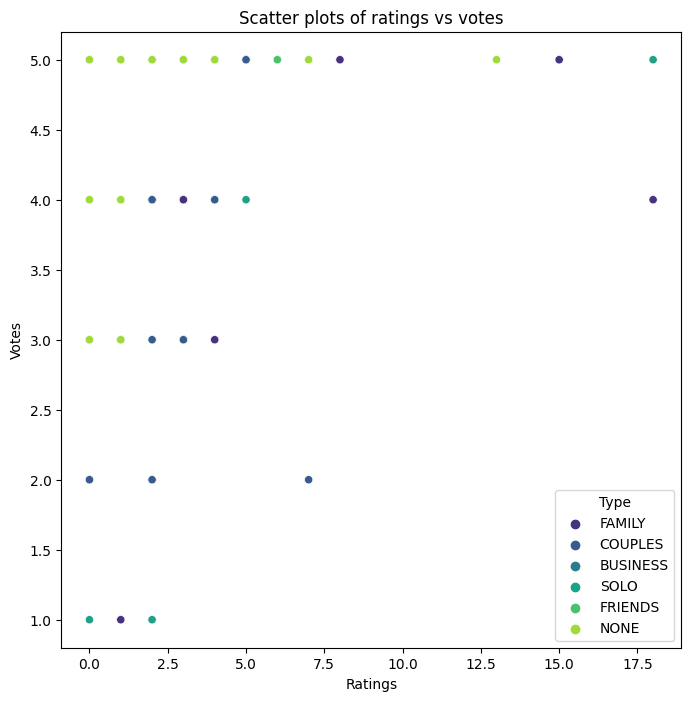

In [21]:
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df_reviews,
    x='votes',
    y='rating',
    hue='type',
    palette='viridis'
)
plt.title("Scatter plots of ratings vs votes")
plt.ylabel('Votes')
plt.xlabel('Ratings')
ax = plt.gca() 
leg = ax.get_legend()
leg.set_title('Type')

plt.show()

This is a good example to advise against using scatter plots for integer vs. integer values, as they don't effectively show the most concentrated combinations (only 30 points were plotted from 1,119 reviews).

### 3.6. Correlation plot

#### 3.6.1. Original columns

In [22]:
int_reviews = df_reviews[['rating', 'votes']]
df_reviews_original_corr = int_reviews.corr()

df_reviews_original_corr

rating     votes
rating  1.000000  0.007825
votes   0.007825  1.000000

<Axes: title={'center': 'Pearson correlation to original columns on reviews data'}>

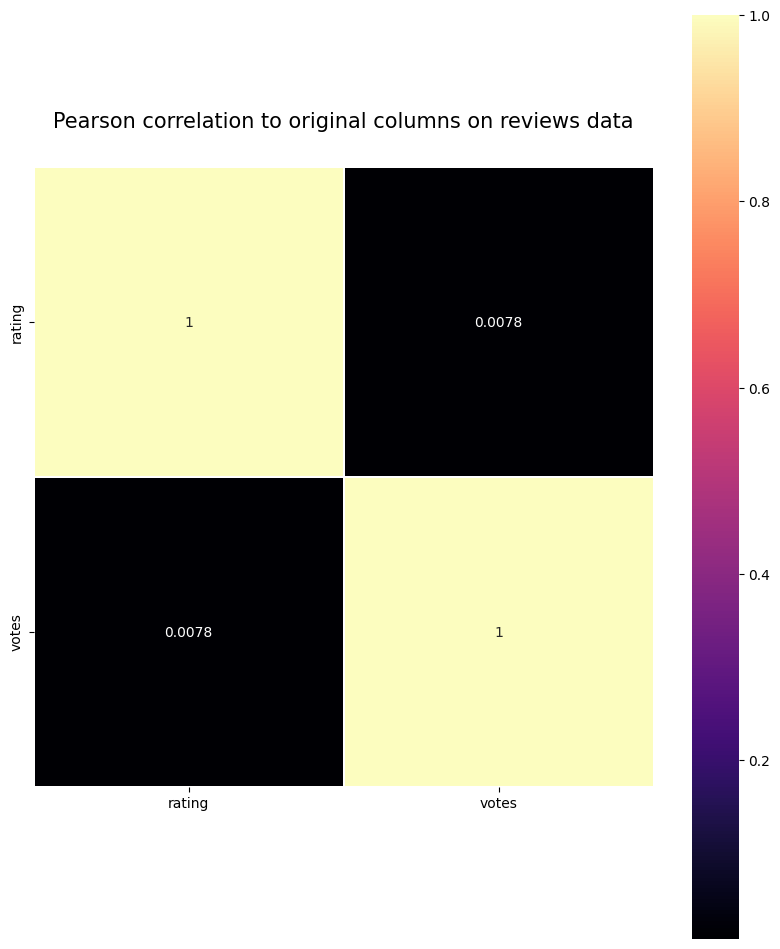

In [23]:
colormap = plt.cm.magma
plt.figure(figsize=(10,12))
plt.title('Pearson correlation to original columns on reviews data', y=1.05, size=15)
sns.heatmap(df_reviews_original_corr,linewidths=0.1,vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)

So, what if the published year and month are considered in the analysis?

#### 3.6.2. Adding published dates stats

In [24]:
# Using previous variables
int_reviews['publishedYear'] = review_year
int_reviews['publishedMonth'] = review_month['monthNumber']

df_reviews_aggdate_corr = int_reviews.corr()

df_reviews_aggdate_corr

rating     votes  publishedYear  publishedMonth
rating          1.000000  0.007825       0.009007       -0.016310
votes           0.007825  1.000000      -0.129389       -0.049586
publishedYear   0.009007 -0.129389       1.000000       -0.057625
publishedMonth -0.016310 -0.049586      -0.057625        1.000000

<Axes: title={'center': 'Pearson correlation to original and date-related columns on reviews data'}>

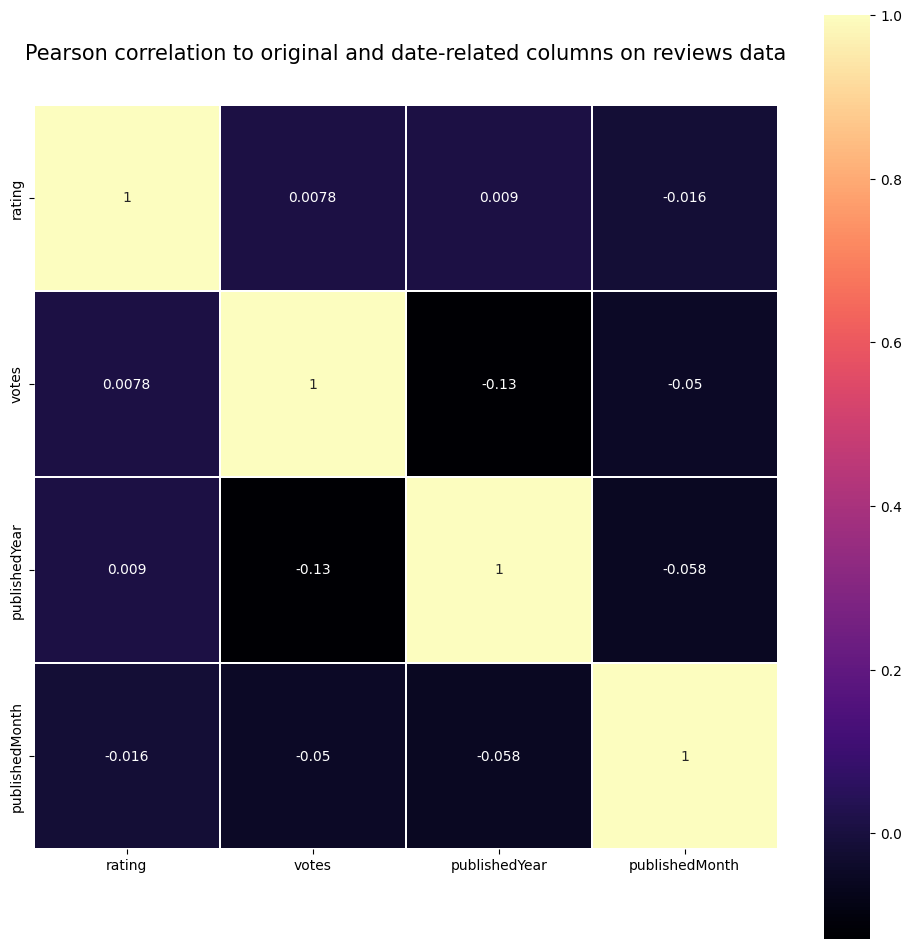

In [25]:
colormap = plt.cm.magma
plt.figure(figsize=(12,12))
plt.title('Pearson correlation to original and date-related columns on reviews data', y=1.05, size=15)
sns.heatmap(df_reviews_aggdate_corr,linewidths=0.1,vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)

# Word clouds

## 1. General word clouds

In [26]:
title_text = ' '.join(df_reviews['title'])
description_text = ' '.join(df_reviews['description'])

wordcloud_alltitles = WordCloud(width=800, height=400, background_color='white').generate(title_text)
wordcloud_alldescriptions = WordCloud(width=800, height=400, background_color='white').generate(description_text)

[]

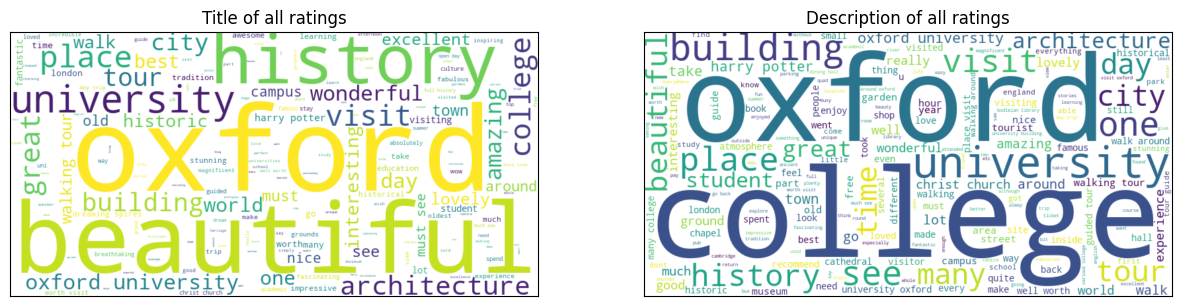

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 20))

axs[0].imshow(wordcloud_alltitles, interpolation='bilinear')
axs[0].set_title(f"Title of all ratings")
axs[0].axis('on')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(wordcloud_alldescriptions, interpolation='bilinear')
axs[1].set_title(f"Description of all ratings")
axs[1].axis('on')
axs[1].set_xticks([])
axs[1].set_yticks([])

##  2. Word clouds by ratings

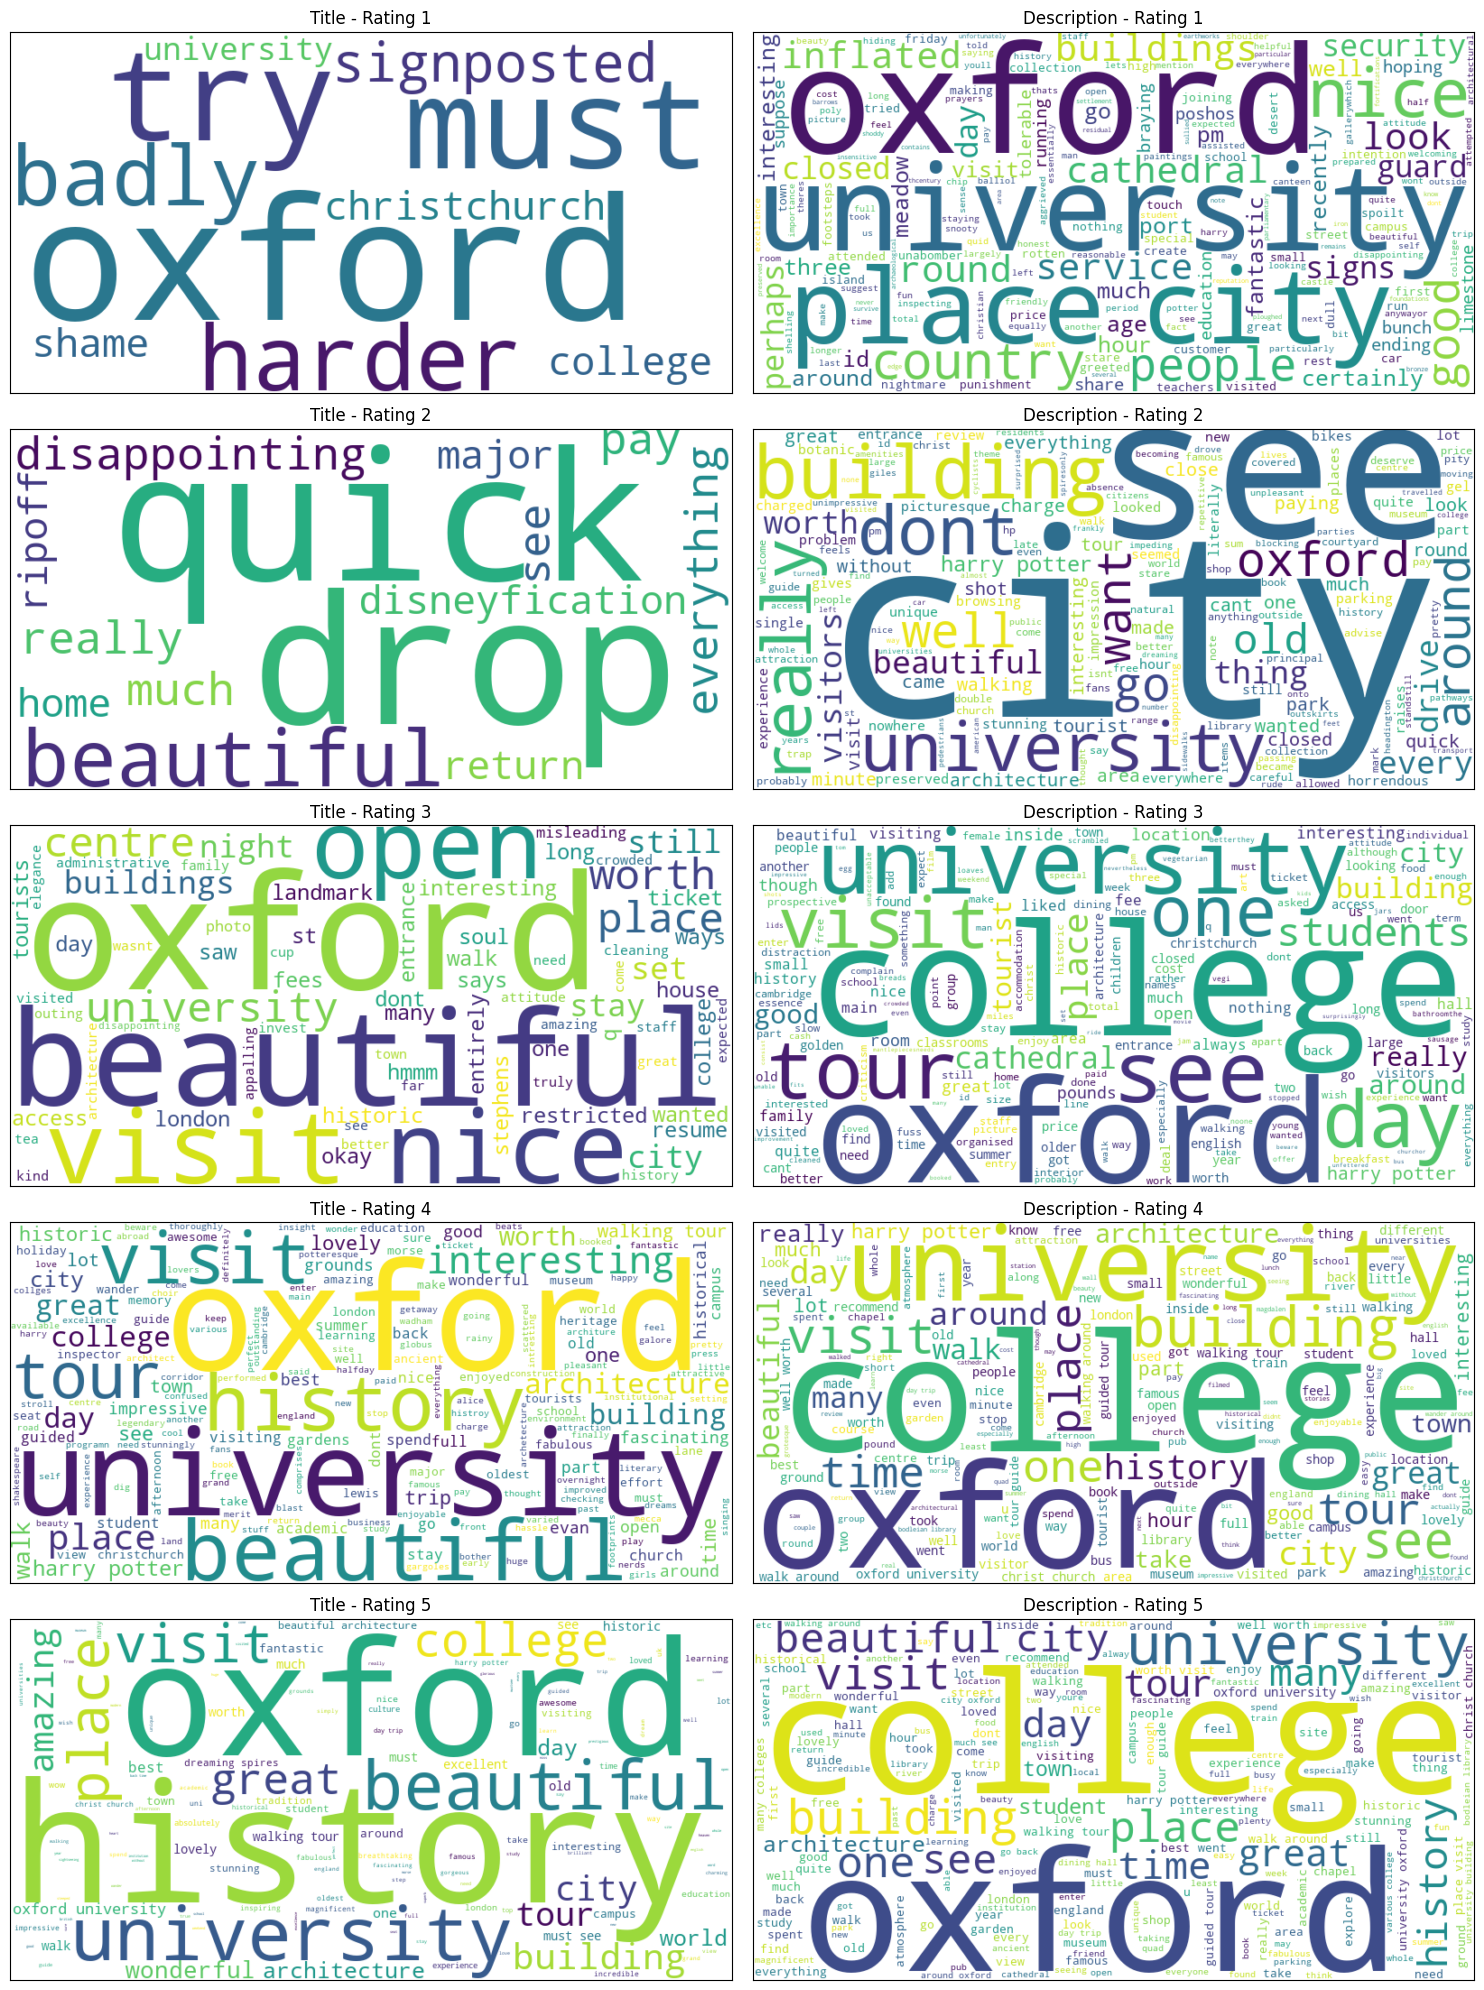

In [28]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for rating in range(1, 6):
    plot_index = rating - 1
    rating_df = df_reviews[df_reviews['rating'] == rating]
    
    ratingtitle_text = ' '.join(rating_df['title'])
    wordcloud_ratingtitles = WordCloud(width=800, height=400, background_color='white').generate(ratingtitle_text)

    axs[plot_index, 0].imshow(wordcloud_ratingtitles, interpolation='bilinear')
    axs[plot_index, 0].set_title(f"Title - Rating {rating}")
    axs[plot_index, 0].axis('on')
    axs[plot_index, 0].set_xticks([])
    axs[plot_index, 0].set_yticks([])

    ratingdescription_text = ' '.join(rating_df['description'])
    wordcloud_ratingdescriptions = WordCloud(width=800, height=400, background_color='white').generate(ratingdescription_text)

    axs[plot_index, 1].imshow(wordcloud_ratingdescriptions, interpolation='bilinear')
    axs[plot_index, 1].set_title(f"Description - Rating {rating}")
    axs[plot_index, 1].axis('on')
    axs[plot_index, 1].set_xticks([])
    axs[plot_index, 1].set_yticks([])

plt.tight_layout()
plt.show()

## 3. Word clouds by trip type

In [29]:
groupedby_type = df_reviews.groupby("type")

n_types = len(groupedby_type)

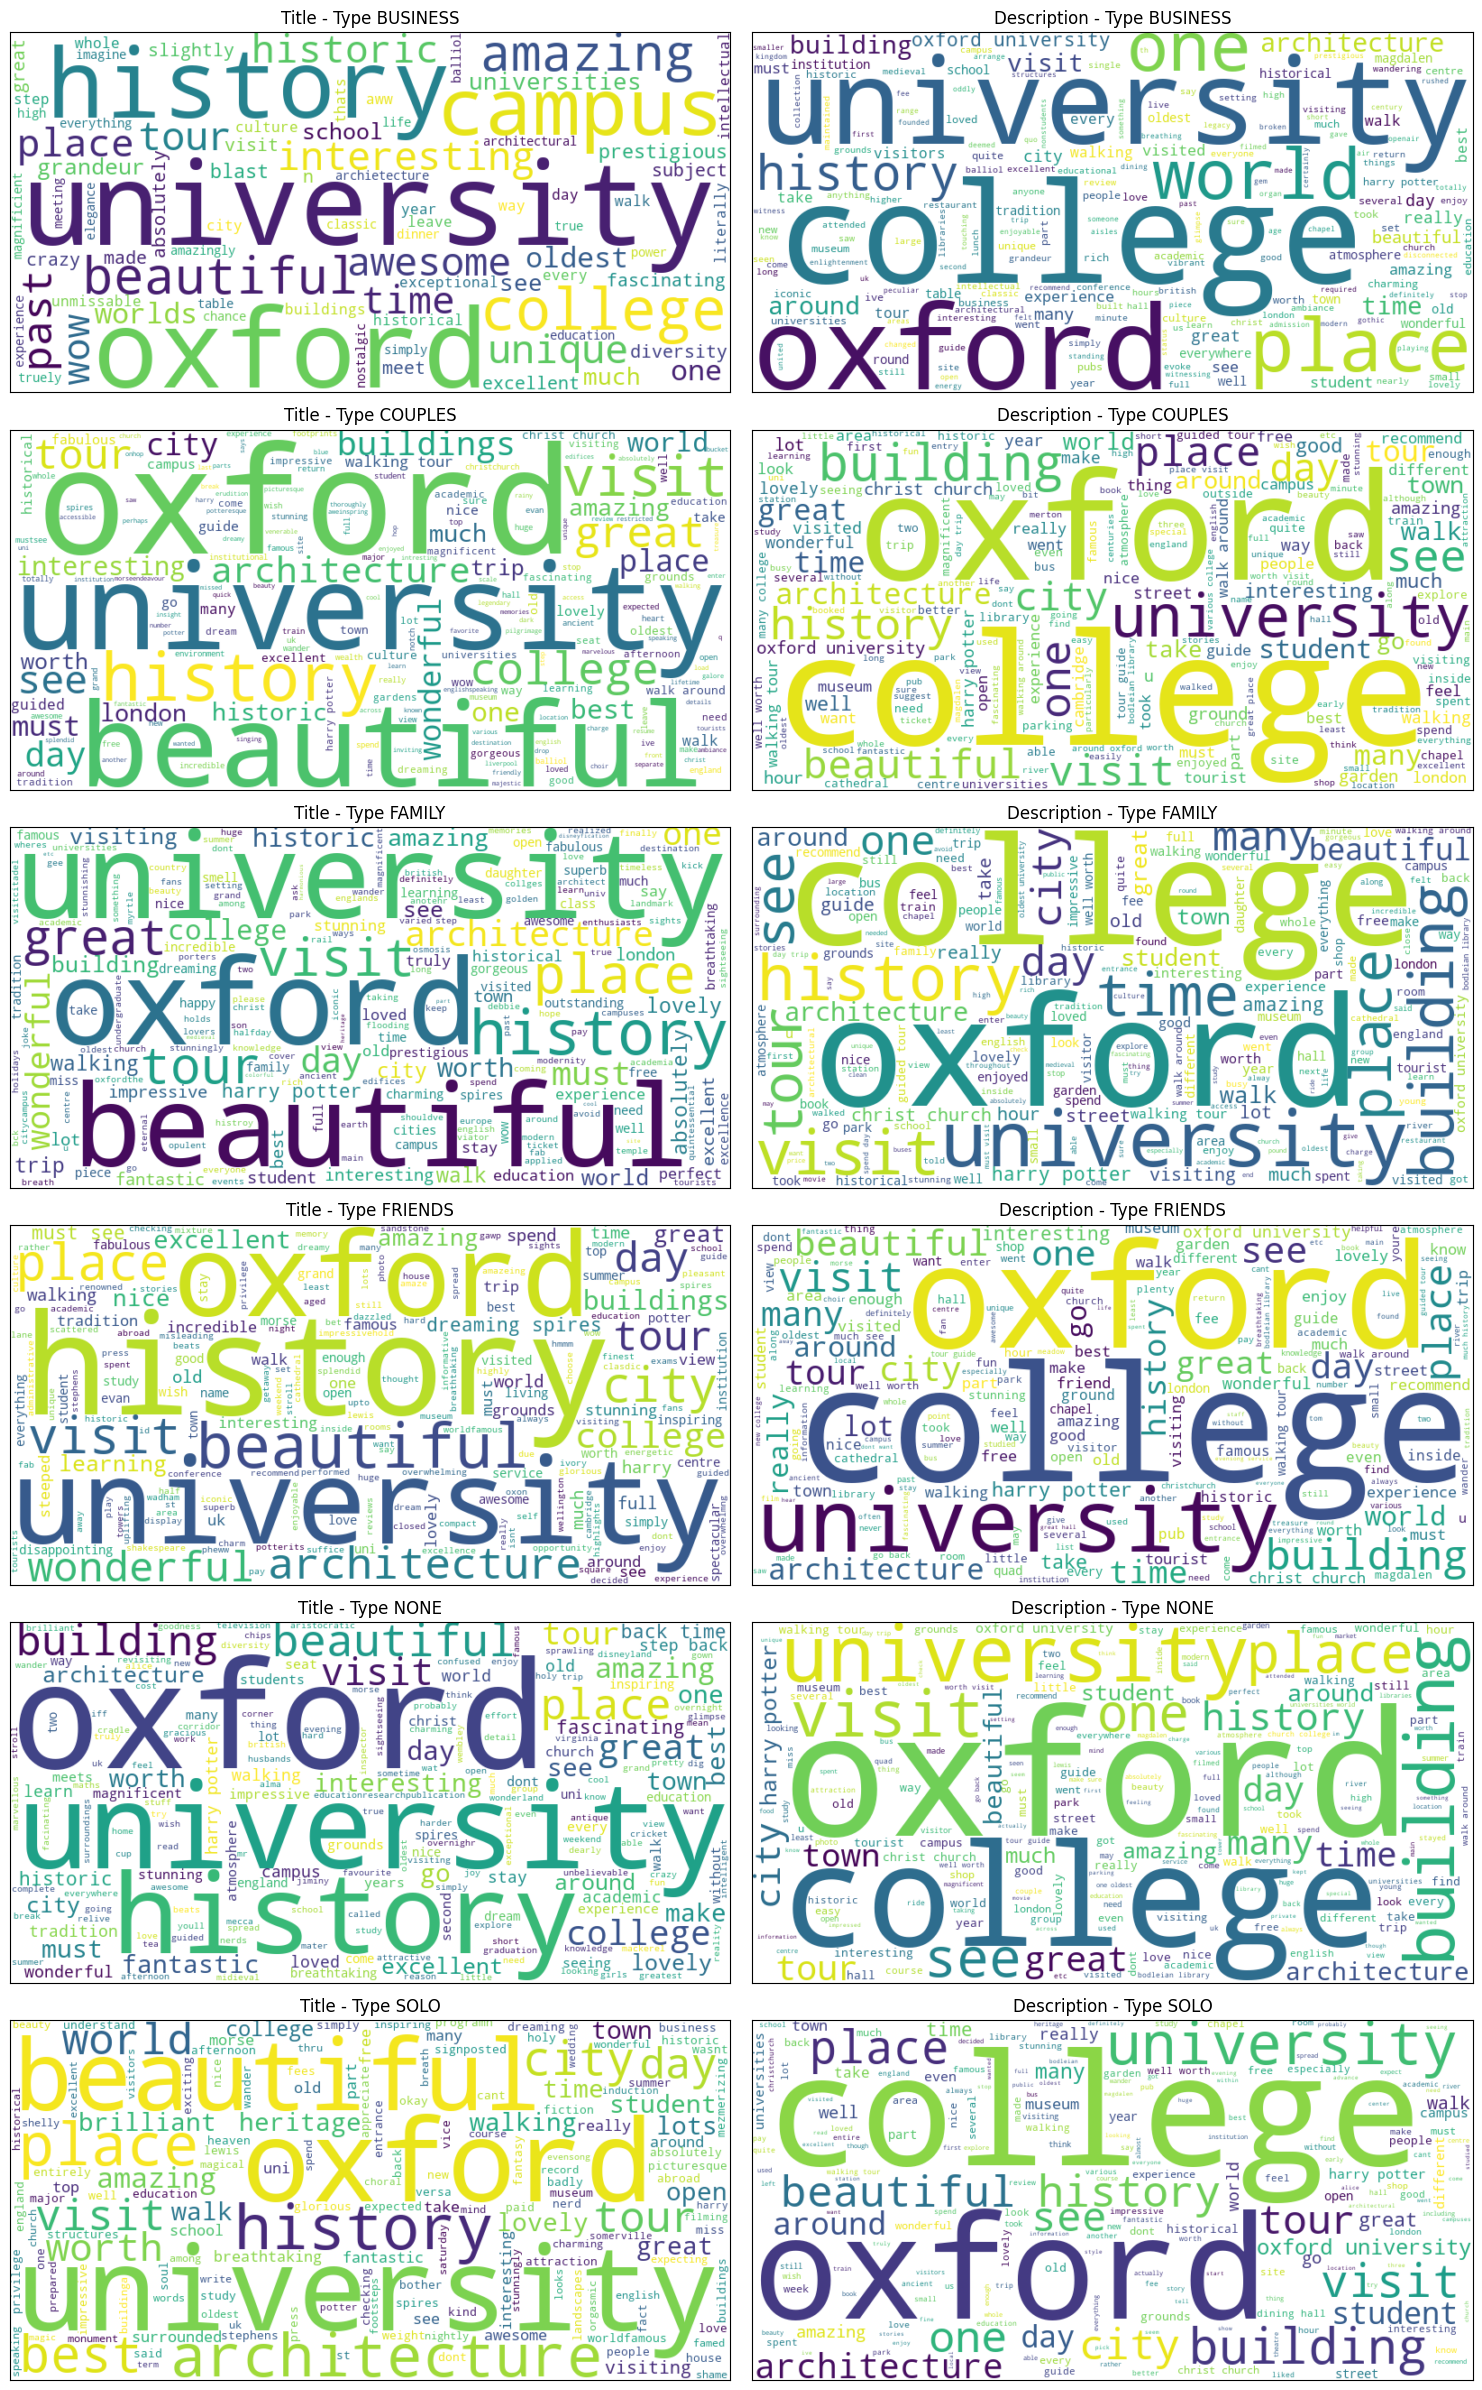

In [30]:
fig, axs = plt.subplots(n_types, 2, figsize=(15, 4*n_types))

for index, (type, type_df) in enumerate(groupedby_type):
    typetitle_text = ' '.join(type_df['title'])
    wordcloud_typetitles = WordCloud(width=800, height=400, background_color='white').generate(typetitle_text)

    axs[index, 0].imshow(wordcloud_typetitles, interpolation='bilinear')
    axs[index, 0].set_title(f"Title - Type {type}")
    axs[index, 0].axis('off')
    axs[index, 0].axis('on')
    axs[index, 0].set_xticks([])
    axs[index, 0].set_yticks([])

    typedescription_text = ' '.join(type_df['description'])
    wordcloud_typedescriptions = WordCloud(width=800, height=400, background_color='white').generate(typedescription_text)

    axs[index, 1].imshow(wordcloud_typedescriptions, interpolation='bilinear')
    axs[index, 1].set_title(f"Description - Type {type}")
    axs[index, 1].axis('off')
    axs[index, 1].axis('on')
    axs[index, 1].set_xticks([])
    axs[index, 1].set_yticks([])

plt.tight_layout()
plt.show()

# Conclusions

- There are more comments with high ratings, indicating that most visitors to the University of Oxford enjoyed their trips.
- Users commonly mention certain words (excluding "Oxford" and "university," as these refer to the destination) to describe the University, such as architecture, building, history, and beauty.
- Most people visit the University of Oxford in couples.
- Most reviewers did not use a mobile device or tablet to write their reviews; they likely used a desktop or laptop instead.
- The numerical variables show weak correlations.
- The number of reviews decreased from 2020, coinciding with the emergency states due to COVID-19.
- Most users wrote their reviews between June and September, which aligns with [the months when the academic year is finished](https://www.ox.ac.uk/admissions/undergraduate/courses/academic-year).

## Potential future works

- In the dataset, there are some non-English titles and descriptions. Using a translator to avoid discarding those comments could improve the results presented here.
- Although this notebook is focused to EDA, a sentimental analysis would fit perfectly using a sentiment scale based on the `ratings` column.
- Based on the words in the title and description, is it possible to predict the rating a user will assign to their review?
- Is the length of the description correlated with the rating or the number of votes the review receives?

# References

Karunarathna, K. (2024). Oxford University Reviews [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/9555411

## Further information

1. [The `assert` statement](https://docs.python.org/3/reference/simple_stmts.html#the-assert-statement)
2. [Method `is_datetime64_any_dtype`](https://pandas.pydata.org/docs/reference/api/pandas.api.types.is_datetime64_any_dtype.html)